<a href="https://colab.research.google.com/github/Jagoda222/LoLa---group-8/blob/main/model_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate -U
!pip install datasets==2.14.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver doe

In [2]:
import torch
from os import path as op
import os
import numpy as np
from collections import Counter
import datasets
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# GPT2
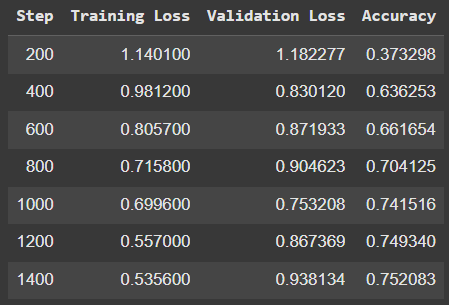

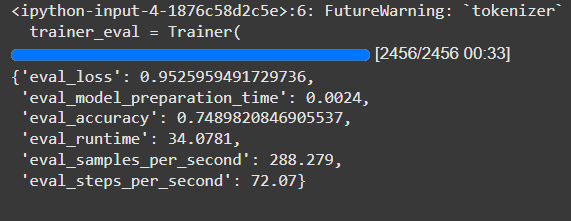

In [3]:
# META Variables
# it is good to have certain directories for saving model checkpoints (e.g., on google drive)
MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "gpt2"
BATCH_SIZE = 16

snli_data = load_dataset("snli")
print(Counter(snli_data['train']['label']))

# SNLI data needs to be cleaned as it contains -1s as a label
for k in snli_data:
    snli_data[k] = snli_data[k].filter( lambda prob: prob['label'] >= 0 )


metric = load_metric('glue', "mnli")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# Add a padding token for GPT-2 since it doesn’t have one by default
tokenizer.pad_token = tokenizer.eos_token

# https://huggingface.co/transformers/preprocessing.html
def preprocess_function(d):
    return tokenizer(d['premise'], d['hypothesis'], truncation=True)


model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

encoded_snli_data = snli_data.map(preprocess_function, batched=True, load_from_cache_file=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    output_dir=MODEL_DIR,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_dir="./logs",
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["validation"],
    # You could use "test" here but it will be cheating then
    # to select the model checkpoint which gets highest score on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Counter({0: 183416, 2: 183187, 1: 182764, -1: 785})


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

<ipython-input-3-0123d2d3e502>:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', "mnli")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-0123d2d3e502>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
200,1.140100,1.182277,0.373298
400,0.981200,0.830120,0.636253
600,0.805700,0.871933,0.661654
800,0.715800,0.904623,0.704125
1000,0.699600,0.753208,0.741516
1200,0.557000,0.867369,0.749340
1400,0.535600,0.938134,0.752083


TrainOutput(global_step=1500, training_loss=0.7879597625732422, metrics={'train_runtime': 528.8622, 'train_samples_per_second': 11.345, 'train_steps_per_second': 2.836, 'total_flos': 99703983015936.0, 'train_loss': 0.7879597625732422, 'epoch': 3.0})

In [4]:
# evaluation of a particular model

# if you want to load a model from a checkpoint for evaluation
# ft_model = AutoModelForSequenceClassification.from_pretrained(op.join(MODEL_DIR, 'checkpoint-5000'))

trainer_eval = Trainer(
    trainer.model, # model that you want to evaluate, In this case this is the best model based on the fine-tuning
    args,
    train_dataset=encoded_snli_data["train"].select(range(2000)),
    eval_dataset=encoded_snli_data["test"], # you want to evaluate on test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_eval.evaluate()

<ipython-input-4-1876c58d2c5e>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_eval = Trainer(


{'eval_loss': 0.9525959491729736,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.7489820846905537,
 'eval_runtime': 34.0781,
 'eval_samples_per_second': 288.279,
 'eval_steps_per_second': 72.07}